# Let's use emcee to see if we can infer the velocity of a star using Adrian's code.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib as mpl
import emcee
import time
import corner

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
from astropy.coordinates.builtin_frames.galactocentric import get_matrix_vectors

import aviary as av

%matplotlib inline

Test the functions for tranforming between position & velocity and proper motion & RV.

In [2]:
sun_xyz = [-8.122, 0, 0] * u.kpc
sun_vxyz = [12.9, 245.6, 7.78] * u.km/u.s

galcen_frame = coord.Galactocentric(galcen_distance=np.abs(sun_xyz[0]),
                                    galcen_v_sun=sun_vxyz,
                                    z_sun=0*u.pc)

# Pre-compute the rotation matrix to go from Galactocentric to ICRS (ra/dec) coordinates
R_gal, _ = get_matrix_vectors(galcen_frame, inverse=True)

#Test the function by transforming a coordinate to galactocentric and back:
c = coord.SkyCoord(ra=61.342*u.deg, 
                   dec=17*u.deg, 
                   distance=3*u.kpc,
                   pm_ra_cosdec=4.2*u.mas/u.yr,
                   pm_dec=-7.2*u.mas/u.yr,
                   radial_velocity=17*u.km/u.s)

test_galcen = c.transform_to(galcen_frame)

We want to infer the velocity and distance of a star from its proper motion in ra and dec, and 3-D position, marginalising over RV.

$$p(V_{xyz}, D|\mu_\alpha, \mu_\delta, \alpha, \delta, \pi) = p(\mu_\alpha, \mu_\delta, \alpha, \delta, \pi| V_{xyz}, D)~p(V_{xyz})~p(D)$$

Test star.

In [3]:
pm = np.array([4.2, -7.2])
pm_err = np.array([.01, .01])
pos = np.array([61.342, 17., 1./3])
pos_err = np.array([.1, .1, .001])
vx, vy, vz = test_galcen.velocity.d_xyz[0].value, test_galcen.velocity.d_xyz[1].value, test_galcen.velocity.d_xyz[2].value

In [6]:
import emcee
import time

ndim, nwalkers = 4, 12
inits = [vx, vy, vz, np.log(3.)]
p0 = np.random.randn(nwalkers, ndim)*1e-4 + inits

sampler = emcee.EnsembleSampler(nwalkers, ndim, av.lnprob, args=(pm, pm_err, pos, pos_err))

start = time.time()
sampler.run_mcmc(p0, 100);
end = time.time()
print(end - start, "s")

6.284460783004761 s


(216, 4) [-0.8922743769410216, 130.44338147766848, -22.052114773047027, 1.0986122886681098]


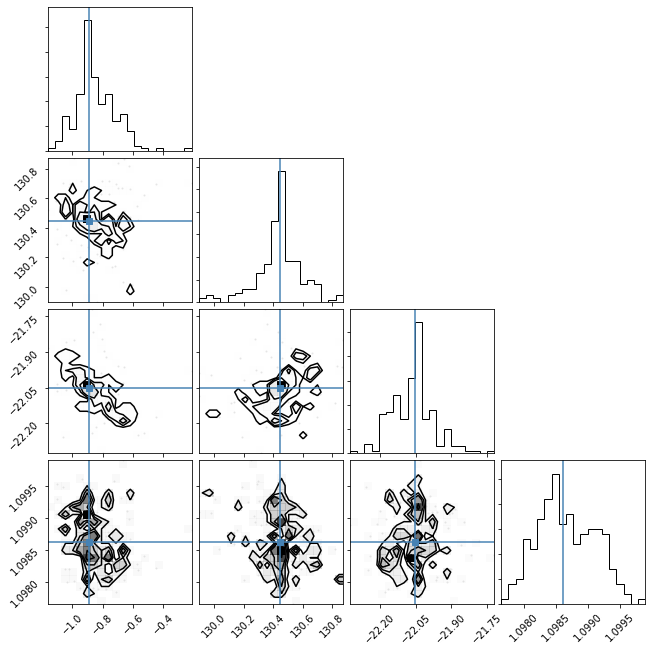

In [7]:
import corner

flat_samples = sampler.get_chain(discard=10, thin=5, flat=True)
print(flat_samples.shape, inits)

fig = corner.corner(flat_samples, truths=inits);

Now the next step is to see if it works on a real star with a known RV! Let's load the McQuillan catalog and use a star as an example.

In [5]:
df0 = pd.read_csv("../../data/gaia_mc5.csv")
m = np.isfinite(df0.vz.values)
print(len(df0.iloc[m]))
df = df0.iloc[m]
print(df.vz.values[0], df.radial_velocity.values[0])

3351
0.4718097427275309 -28.47734729477983


In [6]:
i = 0
df1 = df.iloc[i]

ra, dec, plx = df1.ra, df1.dec, df1.parallax
ra_err, dec_err, plx_err = df1.ra_error, df1.dec_error, df1.parallax_error
pmra, pmdec, rv = df1.pmra, df1.pmdec, df1.radial_velocity
pmra_err, pmdec_err, rv_err = df1.pmra_error, df1.pmdec_error, df1.radial_velocity_error

#Test the function by transforming a coordinate to galactocentric and back:
c = coord.SkyCoord(ra=ra*u.deg, 
                   dec=dec*u.deg, 
                   distance=(1./plx)*u.kpc,
                   pm_ra_cosdec=pmra*u.mas/u.yr,
                   pm_dec=pmdec*u.mas/u.yr,
                   radial_velocity=rv*u.km/u.s)

test_galcen = c.transform_to(galcen_frame)

pm = np.array([pmra, pmdec])
pm_err = np.array([pmra_err, pmdec_err])
pos = np.array([ra, dec, plx])
pos_err = np.array([ra_err, dec_err, plx_err])
vx, vy, vz = test_galcen.velocity.d_xyz[0].value, test_galcen.velocity.d_xyz[1].value, test_galcen.velocity.d_xyz[2].value

print(pm)

[ 7.96896448 10.59041207]


In [8]:
ndim, nwalkers = 4, 24
inits = [vx, vy, vz, np.log(1./plx)]
p0 = np.random.randn(nwalkers, ndim) + inits

sampler = emcee.EnsembleSampler(nwalkers, ndim, av.lnprob, args=(pm, pm_err, pos, pos_err))

sampler.run_mcmc(p0, 500, progress=True);

100%|██████████| 500/500 [01:04<00:00,  7.72it/s]


(2352, 4) [-7.516811357896795, 223.57770337115474, 0.9444379590417658, -1.6782637782895944]


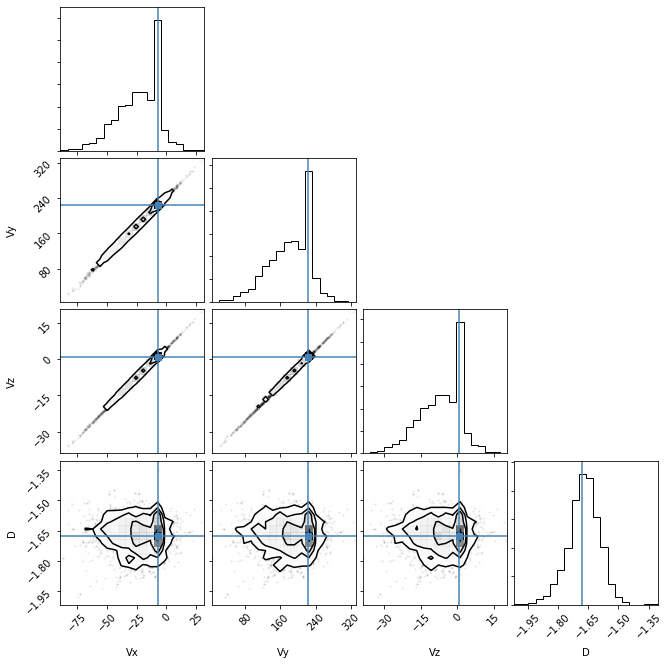

In [9]:
flat_samples = sampler.get_chain(discard=10, thin=5, flat=True)
print(flat_samples.shape, inits)

labels = ["Vx", "Vy", "Vz", "D"]
fig = corner.corner(flat_samples, truths=inits, labels=labels);

0.6088392362066876 11.49624800282592


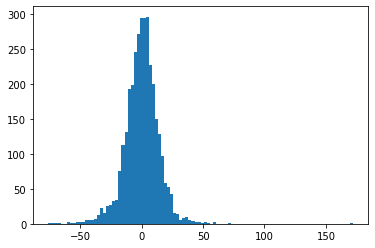

In [40]:
import astropy.stats as aps

plt.hist(df.vz.values, 100);
print(np.median(df.vz.values), 1.5 * aps.median_absolute_deviation(df.vz.values))